In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm

In [24]:
############################# Parte 1 - Analise

# Caminhos dos arquivos
insurance_path = "./data/insurance.csv"
boston_path = "./data/boston.csv"
power_path = "./data/household_power_consumption.txt"

# Carregar os datasets
insurance_df = pd.read_csv(insurance_path)
boston_df = pd.read_csv(boston_path)
power_df = pd.read_csv(power_path, sep=';', na_values=['?'], low_memory=False, dtype=str)

# Exibir informações básicas dos datasets
print(power_df.info())
print(insurance_df.info())
print(boston_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype 
---  ------                 ----- 
 0   Date                   object
 1   Time                   object
 2   Global_active_power    object
 3   Global_reactive_power  object
 4   Voltage                object
 5   Global_intensity       object
 6   Sub_metering_1         object
 7   Sub_metering_2         object
 8   Sub_metering_3         object
dtypes: object(9)
memory usage: 142.5+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64

In [25]:
############################# Parte 2 - Separação 80 20

# Pré-processamento do dataset de Insurance
insurance_df_encoded = insurance_df.copy()
label_encoders = {}
categorical_columns = ["sex", "smoker", "region"]
for col in categorical_columns:
    le = LabelEncoder()
    insurance_df_encoded[col] = le.fit_transform(insurance_df_encoded[col])
    label_encoders[col] = le
X_insurance = insurance_df_encoded.drop(columns=["charges"])
y_insurance = insurance_df_encoded["charges"]
X_train_ins, X_test_ins, y_train_ins, y_test_ins = train_test_split(X_insurance, y_insurance, test_size=0.2, random_state=42)

# Pré-processamento do dataset de Boston
X_boston = boston_df.drop(columns=["MEDV"])
y_boston = boston_df["MEDV"]
X_train_bos, X_test_bos, y_train_bos, y_test_bos = train_test_split(X_boston, y_boston, test_size=0.2, random_state=42)

# Pré-processamento do dataset de Power Consumption
power_df.dropna(inplace=True)
power_df.drop(columns=['Date', 'Time'], inplace=True)
power_df = power_df.astype(float)
X_power = power_df.drop(columns=["Global_active_power"])
y_power = power_df["Global_active_power"]
X_train_pow, X_test_pow, y_train_pow, y_test_pow = train_test_split(X_power, y_power, test_size=0.2, random_state=42)

In [26]:
############################# Parte 3 - Modelagem

# Lista de modelos
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)
}

# Função para treinar e avaliar modelos
def train_and_evaluate(models, X_train, y_train, X_test, y_test):
    results = {}
    predictions = {}
    
    for name, model in models.items():
        errors = {"RMSE": [], "MAE": [], "R2": []}
        last_y_pred = None
        
        for _ in range(30):
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            last_y_pred = y_pred
            errors["RMSE"].append(np.sqrt(mean_squared_error(y_test, y_pred)))
            errors["MAE"].append(mean_absolute_error(y_test, y_pred))
            errors["R2"].append(r2_score(y_test, y_pred))
        
        results[name] = {
            "RMSE": np.mean(errors["RMSE"]),
            "MAE": np.mean(errors["MAE"]),
            "R2": np.mean(errors["R2"])
        }
        
        predictions[name] = {"y_real": y_test, "y_pred": last_y_pred}
    
    return results, predictions

results_insurance, preds_insurance = train_and_evaluate(models, X_train_ins, y_train_ins, X_test_ins, y_test_ins)
results_boston, preds_boston = train_and_evaluate(models, X_train_bos, y_train_bos, X_test_bos, y_test_bos)
results_power, preds_power = train_and_evaluate(models, X_train_pow, y_train_pow, X_test_pow, y_test_pow)

print(f"""
Erros na previsão de preços de seguro (Insurance):
    - Linear Regression:
        - RMSE: {results_insurance['Linear Regression']['RMSE']}
        - MAE:  {results_insurance['Linear Regression']['MAE']}
        - R2:   {results_insurance['Linear Regression']['R2']}
    - Random Forest:
        - RMSE: {results_insurance['Random Forest']['RMSE']}
        - MAE:  {results_insurance['Random Forest']['MAE']}
        - R2:   {results_insurance['Random Forest']['R2']}
    - XGBoost:
        - RMSE: {results_insurance['XGBoost']['RMSE']}
        - MAE:  {results_insurance['XGBoost']['MAE']}
        - R2:   {results_insurance['XGBoost']['R2']}
""")

print(f"""
Erros na previsão de preços de seguro (Insurance):
    - Linear Regression:
        - RMSE: {results_boston['Linear Regression']['RMSE']}
        - MAE:  {results_boston['Linear Regression']['MAE']}
        - R2:   {results_boston['Linear Regression']['R2']}
    - Random Forest:
        - RMSE: {results_boston['Random Forest']['RMSE']}
        - MAE:  {results_boston['Random Forest']['MAE']}
        - R2:   {results_boston['Random Forest']['R2']}
    - XGBoost:
        - RMSE: {results_boston['XGBoost']['RMSE']}
        - MAE:  {results_boston['XGBoost']['MAE']}
        - R2:   {results_boston['XGBoost']['R2']}
""")

print(f"""
Erros na previsão de preços de seguro (Insurance):
    - Linear Regression:
        - RMSE: {results_power['Linear Regression']['RMSE']}
        - MAE:  {results_power['Linear Regression']['MAE']}
        - R2:   {results_power['Linear Regression']['R2']}
    - Random Forest:
        - RMSE: {results_power['Random Forest']['RMSE']}
        - MAE:  {results_power['Random Forest']['MAE']}
        - R2:   {results_power['Random Forest']['R2']}
    - XGBoost:
        - RMSE: {results_power['XGBoost']['RMSE']}
        - MAE:  {results_power['XGBoost']['MAE']}
        - R2:   {results_power['XGBoost']['R2']}
""")


Erros na previsão de preços de seguro (Insurance):
    - Linear Regression:
        - RMSE: 5799.587091438356
        - MAE:  4186.508898366433
        - R2:   0.7833463107364541
    - Random Forest:
        - RMSE: 4590.573538794399
        - MAE:  2533.6746436177555
        - R2:   0.8642606273649588
    - XGBoost:
        - RMSE: 4822.991168492681
        - MAE:  2791.8325179517174
        - R2:   0.8501678977480661


Erros na previsão de preços de seguro (Insurance):
    - Linear Regression:
        - RMSE: 4.928602182665333
        - MAE:  3.189091965887838
        - R2:   0.6687594935356324
    - Random Forest:
        - RMSE: 2.8109631609391226
        - MAE:  2.0395392156862746
        - R2:   0.8922527442109114
    - XGBoost:
        - RMSE: 2.6285417184029893
        - MAE:  1.8908873698290658
        - R2:   0.9057837838492541


Erros na previsão de preços de seguro (Insurance):
    - Linear Regression:
        - RMSE: 0.04036849910904764
        - MAE:  0.02583893035681718

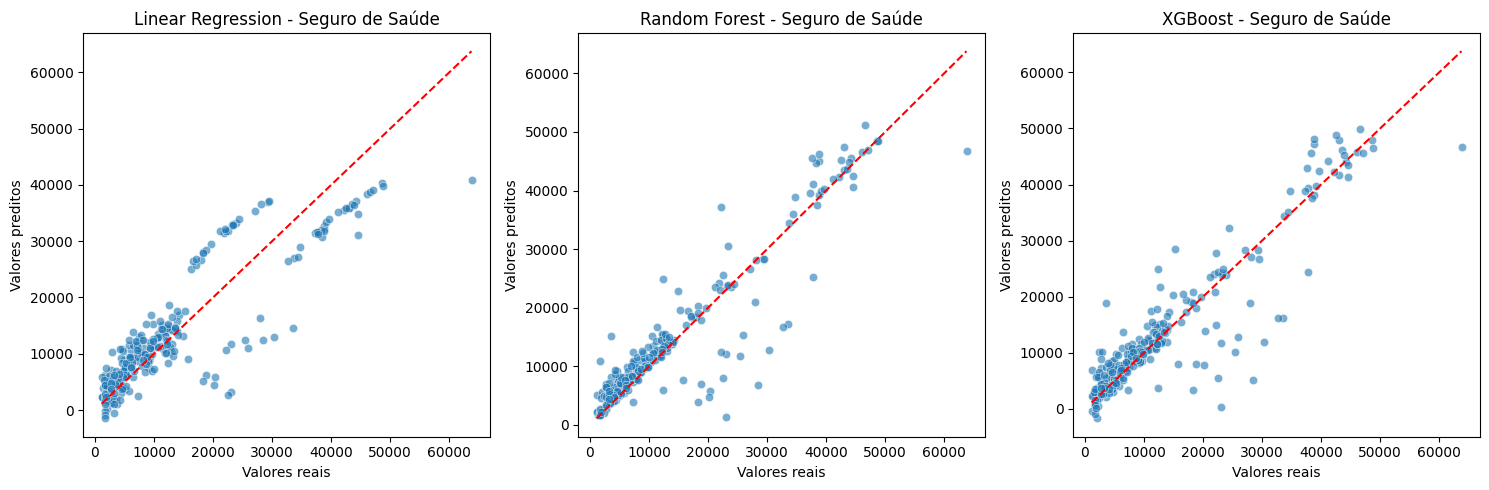

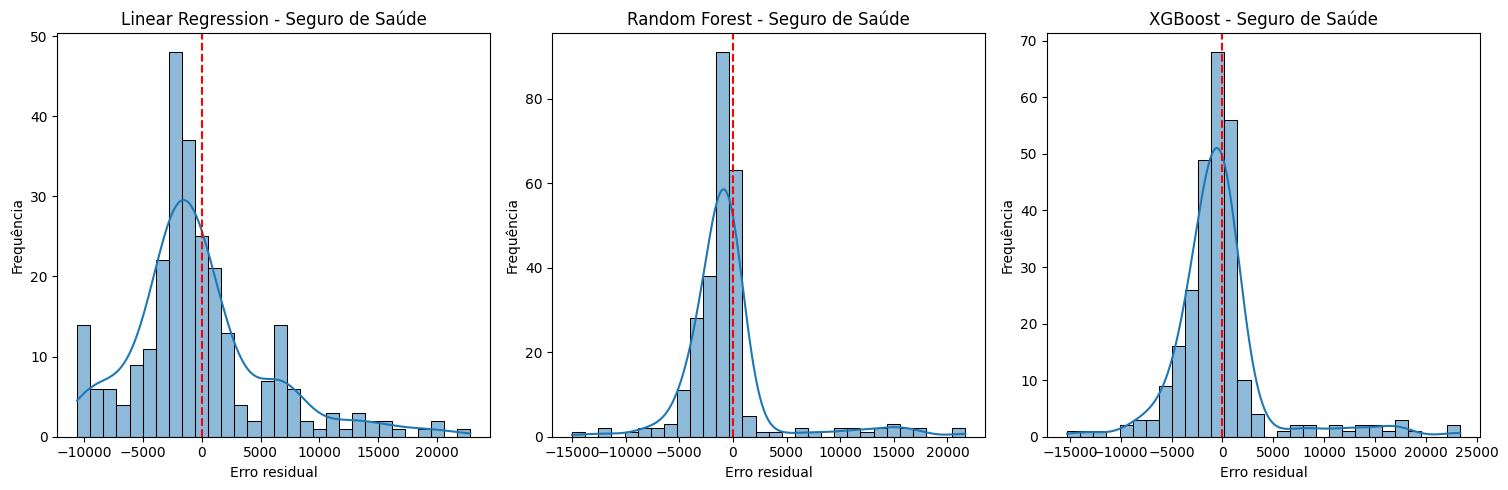

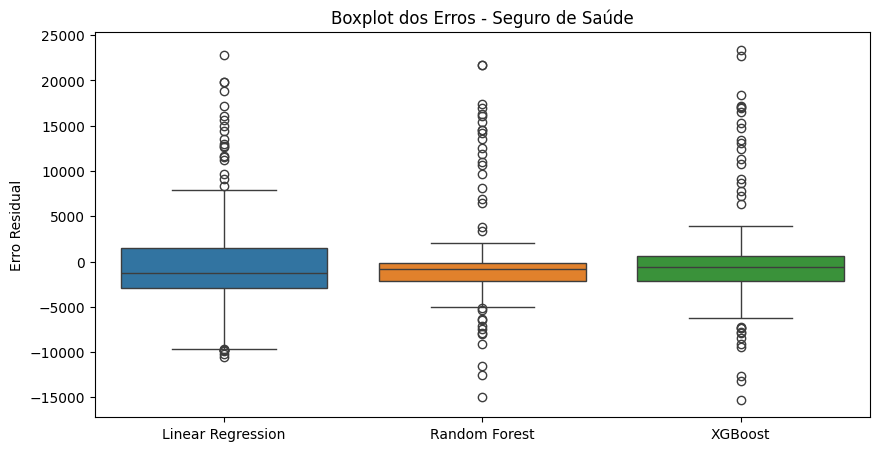

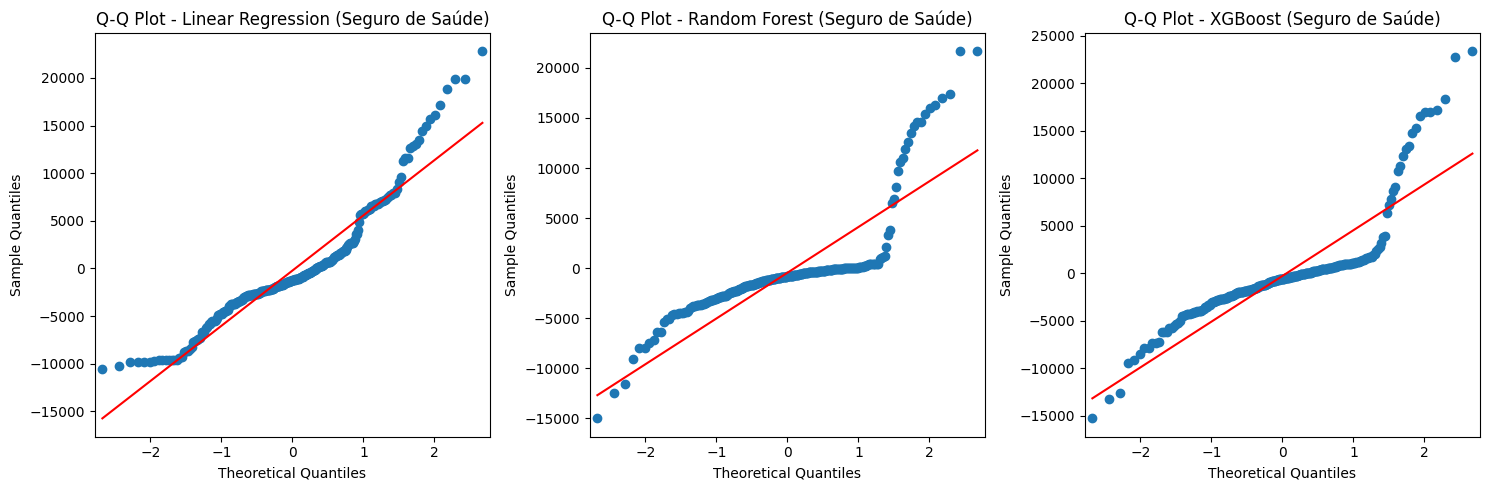

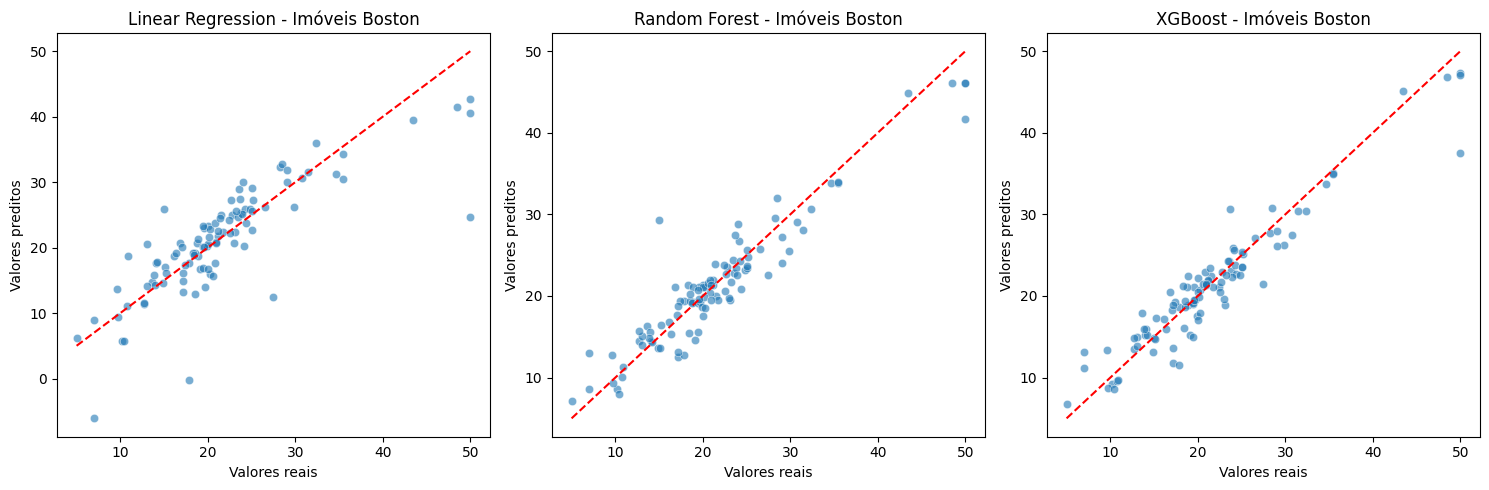

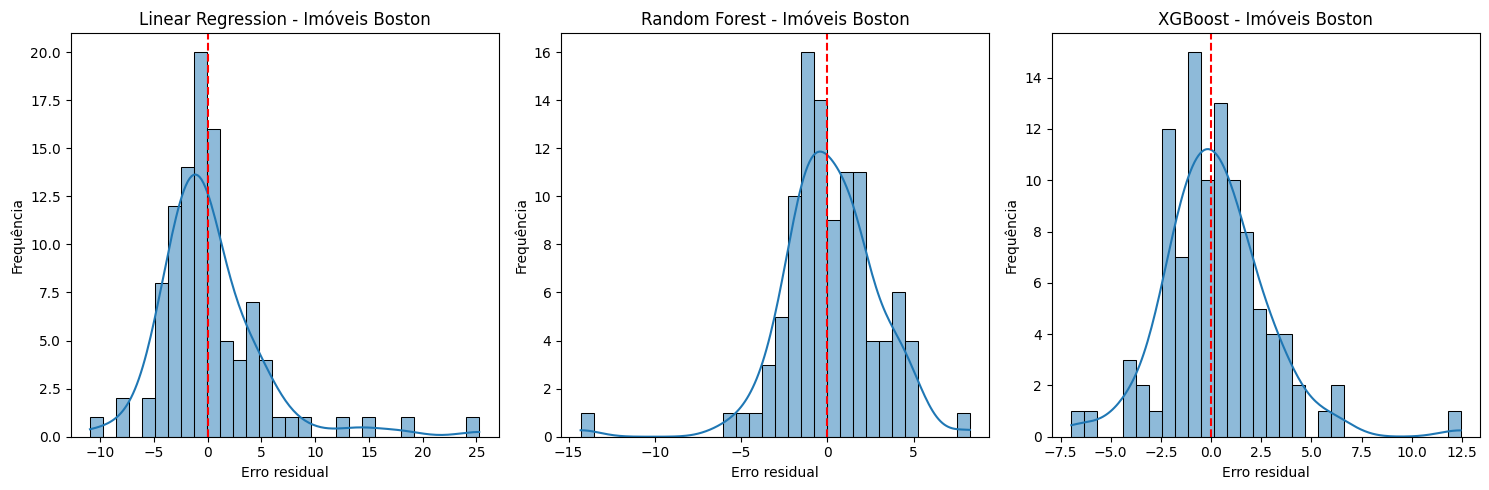

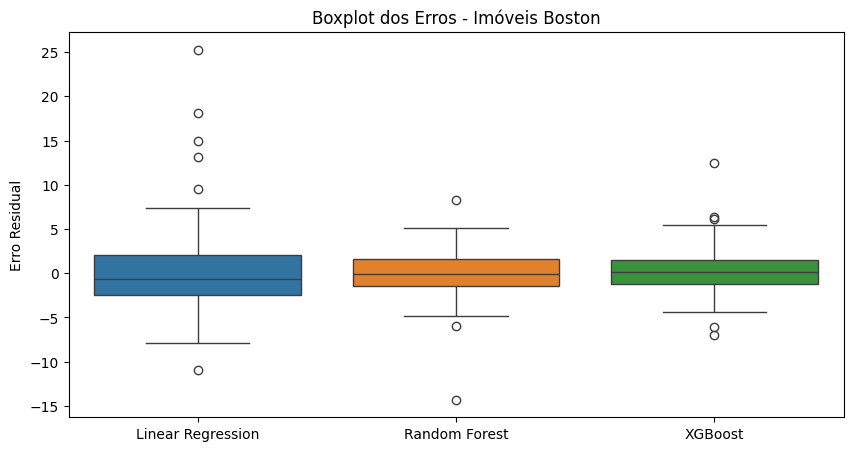

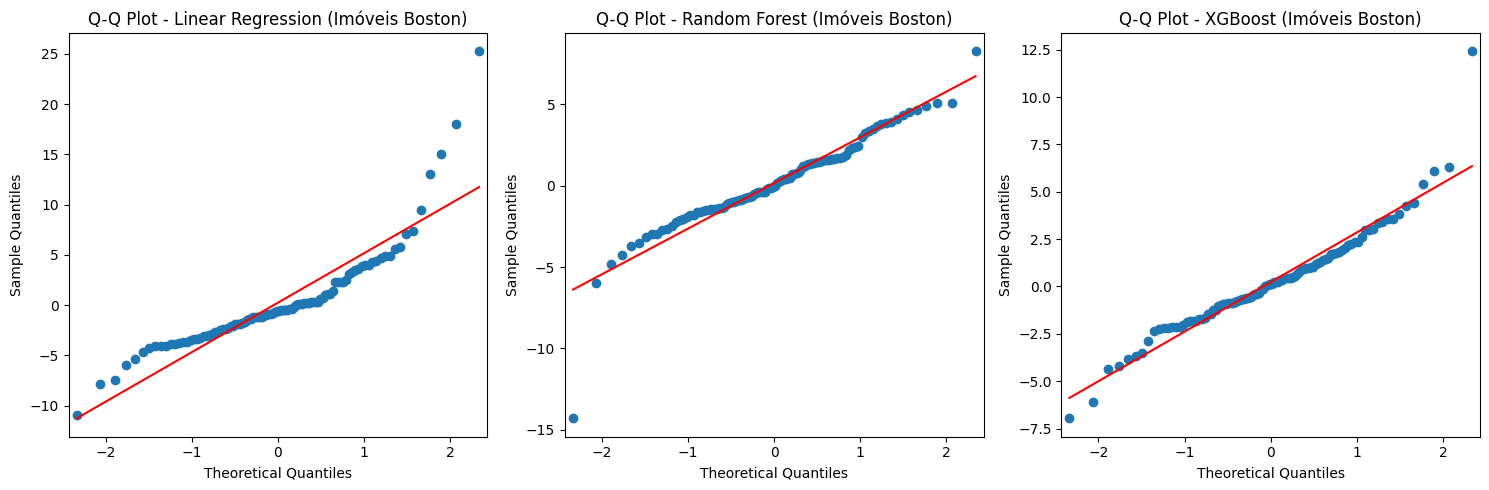

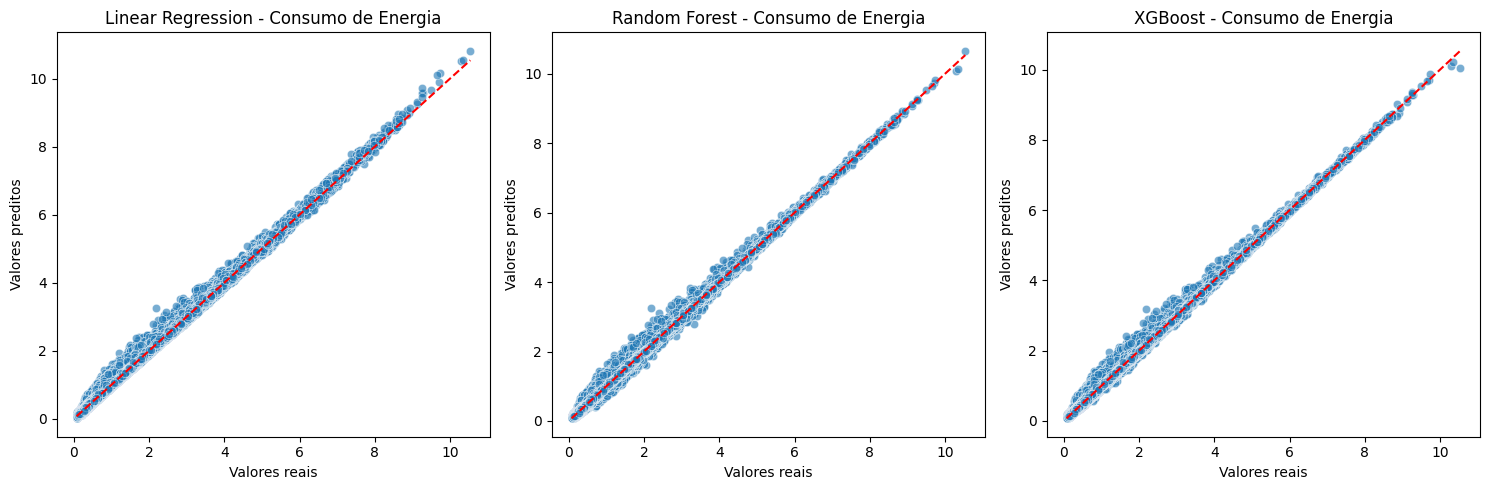

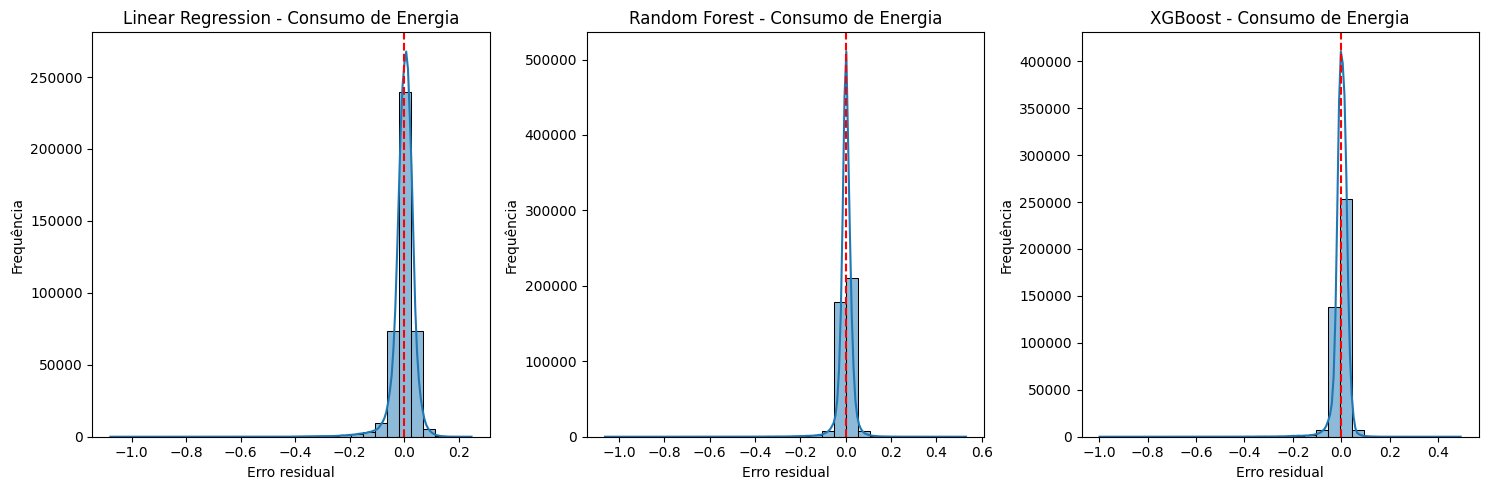

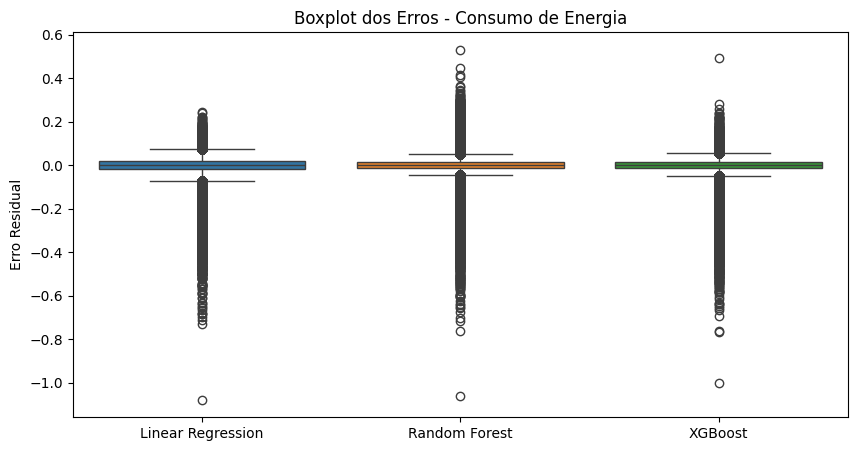

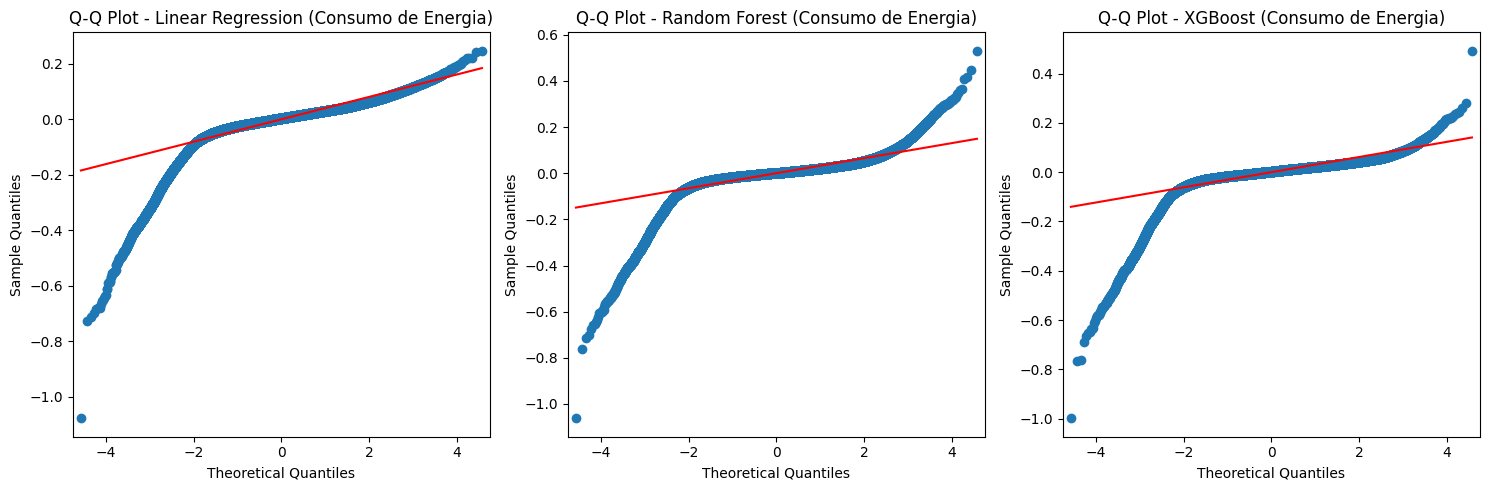

In [27]:
############################# Parte 4 - Estatística

# Função para plotar gráficos de dispersão (Real vs Previsto)
def plot_scatter(predictions, dataset_name):
    plt.figure(figsize=(15, 5))

    for i, (model, data) in enumerate(predictions.items()):
        plt.subplot(1, 3, i+1)
        sns.scatterplot(x=np.array(data["y_real"]), y=np.array(data["y_pred"]), alpha=0.6)
        plt.plot([min(np.array(data["y_real"])), max(np.array(data["y_real"]))],
                 [min(np.array(data["y_real"])), max(np.array(data["y_real"]))],
                 color="red", linestyle="--")
        plt.xlabel("Valores reais")
        plt.ylabel("Valores preditos")
        plt.title(f"{model} - {dataset_name}")

    plt.tight_layout()
    plt.show()

# Função para plotar erros residuais (Histograma)
def plot_residuals(predictions, dataset_name):
    plt.figure(figsize=(15, 5))

    for i, (model, data) in enumerate(predictions.items()):
        residuals = np.array(data["y_real"]) - np.array(data["y_pred"])

        plt.subplot(1, 3, i+1)
        sns.histplot(residuals, kde=True, bins=30)
        plt.axvline(x=0, color="red", linestyle="--")
        plt.xlabel("Erro residual")
        plt.ylabel("Frequência")
        plt.title(f"{model} - {dataset_name}")

    plt.tight_layout()
    plt.show()

# Função para plotar Boxplot dos erros
def plot_boxplot_residuals(predictions, dataset_name):
    plt.figure(figsize=(10, 5))
    residuals_data = {model: np.array(data["y_real"]) - np.array(data["y_pred"]) for model, data in predictions.items()}
    
    sns.boxplot(data=list(residuals_data.values()), showfliers=True)
    plt.xticks(ticks=range(len(predictions)), labels=list(predictions.keys()))
    plt.ylabel("Erro Residual")
    plt.title(f"Boxplot dos Erros - {dataset_name}")
    plt.show()

# Função para fazer o gráfico Q-Q Plot
def plot_qq_plot(predictions, dataset_name):
    plt.figure(figsize=(15, 5))

    for i, (model, data) in enumerate(predictions.items()):
        residuals = np.array(data["y_real"]) - np.array(data["y_pred"])

        plt.subplot(1, 3, i+1)
        sm.qqplot(residuals, line='s', ax=plt.gca())
        plt.title(f"Q-Q Plot - {model} ({dataset_name})")

    plt.tight_layout()
    plt.show()

# Aplicar análises para cada dataset
for preds, dataset in zip([preds_insurance, preds_boston, preds_power], 
                          ["Seguro de Saúde", "Imóveis Boston", "Consumo de Energia"]):
    plot_scatter(preds, dataset)
    plot_residuals(preds, dataset)
    plot_boxplot_residuals(preds, dataset)
    plot_qq_plot(preds, dataset)